In [1]:
import sys
import os
from features_extraction.harralick import Harralick
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import boxcox
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import torch
import logging
from torchvision import transforms
from PIL import Image
import random
import math
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import train_test_split

Features_extraction package loaded!


In [2]:
'''
FUNGSI GENERAL PREPROCESSING UNTUK MELAKUKAN PREPROCESSING SECARA UMUM SEBELUM MASUK KE SPESIFIK PREPROCESSING
'''

def general_preprocessing(file_path):
    try:
        # Load the image
        image = cv2.imread(file_path)
        if image is None:
            raise ValueError(f"Image not loaded: {file_path}")
        
        # Convert to grayscale (example preprocessing step)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Resize the image (example preprocessing step)
        image = cv2.resize(image, (128, 128))
        
        return image
    except Exception as e:
        print(f"Error in preprocessing {file_path}: {e}")
        return None

In [3]:
classes = ["20%", "40%", "60%", "80%", "100%"]

# Menyimpan data gambar dan label
data_baru = []
labels = []

# Iterasi setiap kelas
for label, category in enumerate(classes):
    folder_path = os.path.join('dataset/APPLE RIPENESS LEVELS IMAGE DATASET', f'{category}')
    # print(folder_path)
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        image = general_preprocessing(file_path)
        
        if image is None:
            print(f"Skipping invalid image: {file_path}")
            continue

        # Save valid data
        data_baru.append(image)
        labels.append(label)

In [7]:
len(data_baru), len(labels)

(500, 500)

In [8]:
# Konversi ke array NumPy
data_baru = np.array(data_baru, dtype="float32")
labels = np.array(labels)

print("Jumlah data:", len(data_baru))
print("Jumlah label:", len(labels))

Jumlah data: 500
Jumlah label: 500


In [10]:
data_baru = data_baru.astype(np.uint16)
data_baru.shape

(500, 128, 128)

In [12]:
# Cek Nilai minimum dan maksimum
print(f"Nilai piksel minimum: {np.min(data_baru)}")
print(f"Nilai piksel maksimum: {np.max(data_baru)}")

Nilai piksel minimum: 1
Nilai piksel maksimum: 255


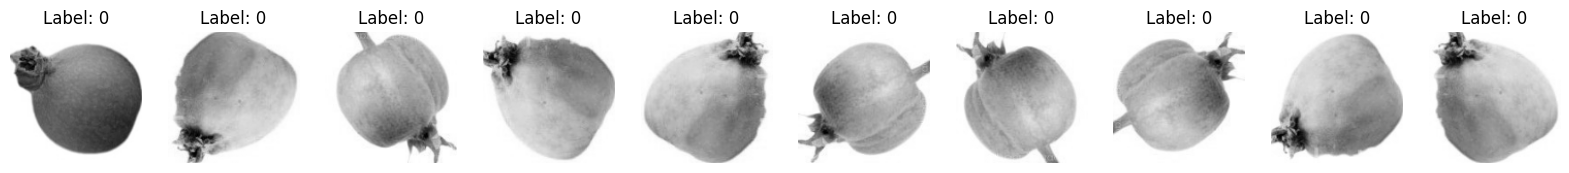

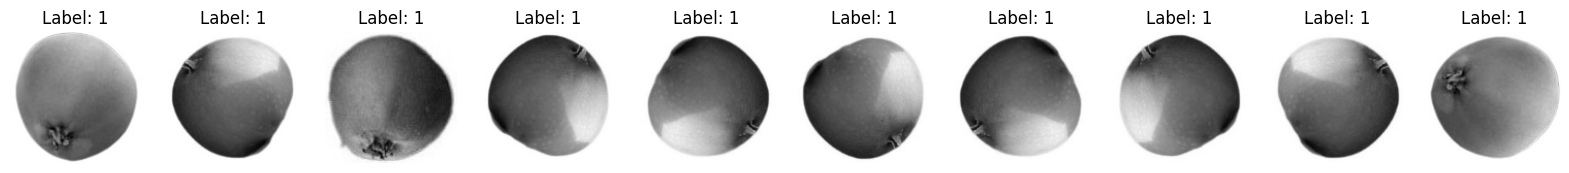

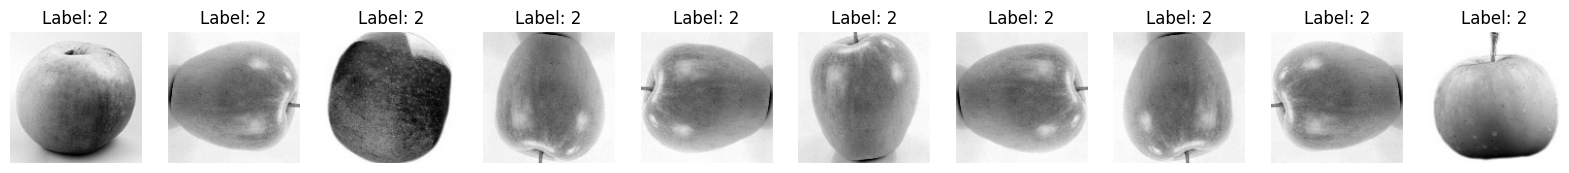

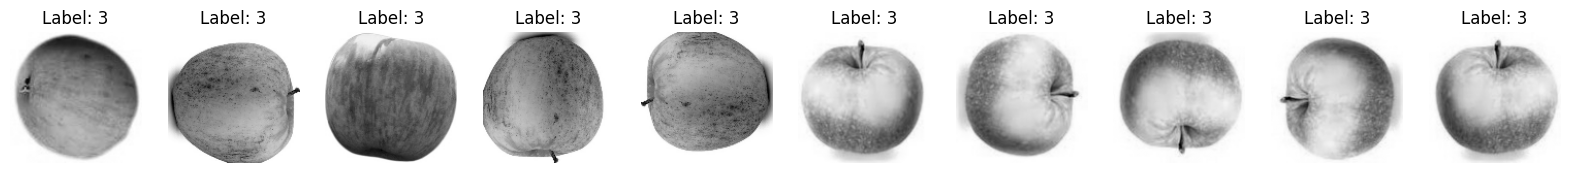

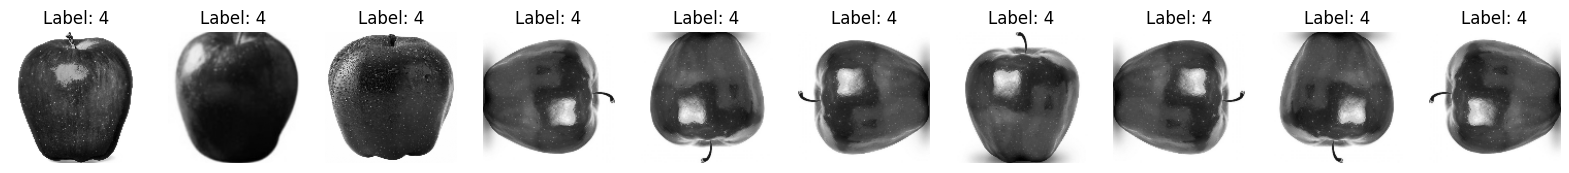

In [14]:
# Menampilkan 10 contoh gambar pertama
num_samples = 10
plt.figure(figsize=(20, 10))

# 10 Label 0 (20%)
for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(data_baru[i], cmap="gray")  # cmap="gray" agar sesuai dengan grayscale
    plt.title(f"Label: {labels[i]}")
    plt.axis("off")

plt.show()

plt.figure(figsize=(20, 10))
# 10 Label 1 (40%)
for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(data_baru[100+i], cmap="gray")  # cmap="gray" agar sesuai dengan grayscale
    plt.title(f"Label: {labels[100+i]}")
    plt.axis("off")

plt.show()

plt.figure(figsize=(20, 10))
# 10 Label 2 (60%)
for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(data_baru[200+i], cmap="gray")  # cmap="gray" agar sesuai dengan grayscale
    plt.title(f"Label: {labels[200+i]}")
    plt.axis("off")

plt.show()

plt.figure(figsize=(20, 10))
# 10 Label 2 (80%)
for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(data_baru[300+i], cmap="gray")  # cmap="gray" agar sesuai dengan grayscale
    plt.title(f"Label: {labels[300+i]}")
    plt.axis("off")

plt.show()

plt.figure(figsize=(20, 10))
# 10 Label 2 (100%)
for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(data_baru[400+i], cmap="gray")  # cmap="gray" agar sesuai dengan grayscale
    plt.title(f"Label: {labels[400+i]}")
    plt.axis("off")

plt.show()



In [15]:
# Function to calculate additional Haralick features
def calculate_additional_features(glcm):
    features = {}
    # Sum of squares: Variance
    features['sum_of_squares'] = np.sum((np.arange(glcm.shape[0]) - np.mean(glcm))**2 * glcm)

    # Sum average
    px_plus_py = np.sum(glcm, axis=0) + np.sum(glcm, axis=1)
    features['sum_average'] = np.sum(np.arange(len(px_plus_py)) * px_plus_py)

    # Sum variance
    features['sum_variance'] = np.sum((np.arange(len(px_plus_py)) - features['sum_average'])**2 * px_plus_py)

    # Sum entropy
    features['sum_entropy'] = -np.sum(px_plus_py * np.log2(px_plus_py + 1e-10))

    # Difference variance
    px_minus_py = np.abs(np.sum(glcm, axis=0) - np.sum(glcm, axis=1))
    features['difference_variance'] = np.var(px_minus_py)

    # Difference entropy
    features['difference_entropy'] = -np.sum(px_minus_py * np.log2(px_minus_py + 1e-10))

    # Information measure of correlation 1
    hxy = -np.sum(glcm * np.log2(glcm + 1e-10))
    hxy1 = -np.sum(np.sum(glcm, axis=0) * np.log2(np.sum(glcm, axis=0) + 1e-10))
    hxy2 = -np.sum(np.sum(glcm, axis=1) * np.log2(np.sum(glcm, axis=1) + 1e-10))
    features['IMC1'] = (hxy - hxy1) / max(hxy, hxy2)

    # Information measure of correlation 2
    hx = -np.sum(np.sum(glcm, axis=0) * np.log2(np.sum(glcm, axis=0) + 1e-10))
    hy = -np.sum(np.sum(glcm, axis=1) * np.log2(np.sum(glcm, axis=1) + 1e-10))
    features['IMC2'] = np.sqrt(1 - np.exp(-2 * (hxy - hx - hy)))

    return features

In [16]:
# Kombinasi d dan theta
kombinasiFeature = [[1, 2, 3], [0, 45, 90, 135]]  # Angles in degrees

# Dictionary to store DataFrames for each combination
feature_dataframes_test = {}

for d in kombinasiFeature[0]:
    for theta in kombinasiFeature[1]:
        data_fitur = []  # List untuk menyimpan fitur semua gambar untuk kombinasi ini
        img = 0  # Index untuk data
        for index in range(len(data_baru)):
            try:
                # Konversi sudut ke radian untuk perhitungan
                theta_in_radians = np.deg2rad(theta)

                # Hitung Matriks GLCM
                glcm_matrix = graycomatrix(data_baru[index], distances=[d], angles=[theta_in_radians], levels=256, symmetric=True, normed=True)

                # Hitung fitur Haralick dari matriks GLCM
                features = {
                    'contrast': graycoprops(glcm_matrix, 'contrast')[0, 0],
                    'dissimilarity': graycoprops(glcm_matrix, 'dissimilarity')[0, 0],
                    'homogeneity': graycoprops(glcm_matrix, 'homogeneity')[0, 0],
                    'energy': graycoprops(glcm_matrix, 'energy')[0, 0],
                    'correlation': graycoprops(glcm_matrix, 'correlation')[0, 0],
                    'ASM': graycoprops(glcm_matrix, 'ASM')[0, 0],
                    'image': f'img-{img}',
                    'label': labels[index]
                }

                # Tambahkan fitur tambahan jika diperlukan
                additional_features = calculate_additional_features(glcm_matrix[:, :, 0, 0])
                features.update(additional_features)

                data_fitur.append(features)
                img += 1
            except Exception as e:
                print(e)

        # Simpan DataFrame ke dictionary dengan kunci (d, theta dalam derajat)
        if data_fitur:
            df = pd.DataFrame(data_fitur)
            feature_dataframes_test[(d, theta)] = df
            print(f"Data untuk d={d}, theta={theta} berhasil dihitung dan disimpan ke dalam memori!")
        else:
            print(f"Tidak ada data untuk d={d}, theta={theta}. Tidak ada DataFrame yang dibuat.")

# Contoh analisis:
# print(feature_dataframes_test[(1, 0)].head())  # Menampilkan data untuk d=1, theta=0

C:\Users\Deva\AppData\Local\Temp\ipykernel_19684\3487331942.py:33: RuntimeWarning: invalid value encountered in sqrt
  features['IMC2'] = np.sqrt(1 - np.exp(-2 * (hxy - hx - hy)))


Data untuk d=1, theta=0 berhasil dihitung dan disimpan ke dalam memori!
Data untuk d=1, theta=45 berhasil dihitung dan disimpan ke dalam memori!
Data untuk d=1, theta=90 berhasil dihitung dan disimpan ke dalam memori!
Data untuk d=1, theta=135 berhasil dihitung dan disimpan ke dalam memori!
Data untuk d=2, theta=0 berhasil dihitung dan disimpan ke dalam memori!
Data untuk d=2, theta=45 berhasil dihitung dan disimpan ke dalam memori!
Data untuk d=2, theta=90 berhasil dihitung dan disimpan ke dalam memori!
Data untuk d=2, theta=135 berhasil dihitung dan disimpan ke dalam memori!
Data untuk d=3, theta=0 berhasil dihitung dan disimpan ke dalam memori!
Data untuk d=3, theta=45 berhasil dihitung dan disimpan ke dalam memori!
Data untuk d=3, theta=90 berhasil dihitung dan disimpan ke dalam memori!
Data untuk d=3, theta=135 berhasil dihitung dan disimpan ke dalam memori!


In [17]:
feature_dataframes_test.keys()

dict_keys([(1, 0), (1, 45), (1, 90), (1, 135), (2, 0), (2, 45), (2, 90), (2, 135), (3, 0), (3, 45), (3, 90), (3, 135)])

In [18]:
df_test = feature_dataframes_test[(1, 45)].copy()  # Copy DataFrame for further processing
df_test = df_test.set_index('image')

In [19]:
df_test

,contrast,dissimilarity,homogeneity,energy,correlation,ASM,label,sum_of_squares,sum_average,sum_variance,sum_entropy,difference_variance,difference_entropy,IMC1,IMC2
image,,,,,,,,,,,,,,,
img-0,170.169074,5.243040,0.454199,0.275247,0.982823,0.075761,0,33375.443085,337.176328,66750.896460,9.529845,4.280309e-36,1.084724e-14,0.350331,NaN
img-1,134.079670,5.363941,0.377222,0.153950,0.973539,0.023701,0,40790.904844,391.189968,81581.821626,11.008009,7.757876e-36,1.513590e-14,0.354075,NaN
img-2,92.735631,4.597495,0.426336,0.241084,0.979740,0.058121,0,43746.253908,407.223076,87492.520243,9.748284,2.282331e-36,6.402818e-15,0.358461,NaN
img-3,123.654845,5.014756,0.396006,0.150844,0.975562,0.022754,0,40781.855368,391.161696,81563.722673,11.048323,7.623568e-36,1.522234e-14,0.347516,NaN
img-4,134.580755,5.389981,0.373784,0.147675,0.973381,0.021808,0,40772.555350,391.124744,81545.122636,11.082890,4.309333e-36,1.307036e-14,0.354128,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
img-495,153.614607,6.916238,0.328482,0.190010,0.964735,0.036104,4,37080.460850,373.643871,74160.933102,9.427772,5.946111e-36,7.528331e-15,0.408870,NaN
img-496,154.357927,6.695207,0.329018,0.183176,0.964519,0.033554,4,37046.839456,373.479013,74093.690309,9.493720,3.117751e-36,6.971878e-15,0.405806,NaN
img-497,569.899994,10.872776,0.379308,0.281821,0.963405,0.079423,4,27891.300744,283.582429,55782.610143,9.542955,6.090702e-36,8.282875e-15,0.388212,NaN


In [20]:
df_test.isnull().sum()

contrast                 0
dissimilarity            0
homogeneity              0
energy                   0
correlation              0
ASM                      0
label                    0
sum_of_squares           0
sum_average              0
sum_variance             0
sum_entropy              0
difference_variance      0
difference_entropy       0
IMC1                     0
IMC2                   500
dtype: int64

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# Pisahkan fitur (X) dan label (y)
X = df_test.drop(columns=['label', 'IMC2'])  # Semua kolom kecuali 'label'
y = df_test['label']  # Kolom 'label'

# Bagi data menjadi training dan testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [25]:
# Inisialisasi model KNN
for k in range(3, 10, 2):
    knn = KNeighborsClassifier(n_neighbors=k)  # Gunakan 3 tetangga terdekat (k=3)

    # Latih model dengan data training
    knn.fit(X_train, y_train)

    # Prediksi label untuk data testing
    y_pred = knn.predict(X_test)

    # Evaluasi performa model
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    print("Accuracy Score:")
    print(accuracy_score(y_test, y_pred))

    print('-----------------------------------------')

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.92        39
           1       0.82      1.00      0.90        23
           2       0.85      0.88      0.87        26
           3       0.93      0.90      0.92        31
           4       0.86      0.77      0.81        31

    accuracy                           0.89       150
   macro avg       0.88      0.89      0.88       150
weighted avg       0.89      0.89      0.89       150

Accuracy Score:
0.8866666666666667
-----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.82      0.88        39
           1       0.70      1.00      0.82        23
           2       0.83      0.92      0.87        26
           3       0.90      0.84      0.87        31
           4       0.72      0.58      0.64        31

    accuracy                           0.82       150
   macro

In [30]:
df_test

,contrast,dissimilarity,homogeneity,energy,correlation,ASM,label,sum_of_squares,sum_average,sum_variance,sum_entropy,difference_variance,difference_entropy,IMC1,IMC2
image,,,,,,,,,,,,,,,
img-0,170.169074,5.243040,0.454199,0.275247,0.982823,0.075761,0,33375.443085,337.176328,66750.896460,9.529845,4.280309e-36,1.084724e-14,0.350331,NaN
img-1,134.079670,5.363941,0.377222,0.153950,0.973539,0.023701,0,40790.904844,391.189968,81581.821626,11.008009,7.757876e-36,1.513590e-14,0.354075,NaN
img-2,92.735631,4.597495,0.426336,0.241084,0.979740,0.058121,0,43746.253908,407.223076,87492.520243,9.748284,2.282331e-36,6.402818e-15,0.358461,NaN
img-3,123.654845,5.014756,0.396006,0.150844,0.975562,0.022754,0,40781.855368,391.161696,81563.722673,11.048323,7.623568e-36,1.522234e-14,0.347516,NaN
img-4,134.580755,5.389981,0.373784,0.147675,0.973381,0.021808,0,40772.555350,391.124744,81545.122636,11.082890,4.309333e-36,1.307036e-14,0.354128,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
img-495,153.614607,6.916238,0.328482,0.190010,0.964735,0.036104,4,37080.460850,373.643871,74160.933102,9.427772,5.946111e-36,7.528331e-15,0.408870,NaN
img-496,154.357927,6.695207,0.329018,0.183176,0.964519,0.033554,4,37046.839456,373.479013,74093.690309,9.493720,3.117751e-36,6.971878e-15,0.405806,NaN
img-497,569.899994,10.872776,0.379308,0.281821,0.963405,0.079423,4,27891.300744,283.582429,55782.610143,9.542955,6.090702e-36,8.282875e-15,0.388212,NaN


In [95]:
# Normalisasi dengan Min-Max Scaling
numeric_features = df_test.drop(columns=['label', 'IMC2'], axis=1).columns

df_ngetestt = df_test.copy()
scaler = MinMaxScaler()
df_ngetestt[numeric_features] = scaler.fit_transform(df_ngetestt[numeric_features])

In [98]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import pandas as pd

# Dictionary untuk menyimpan hasil akurasi
results = {}

# Iterasi melalui semua kombinasi (d, theta)
for (d, theta), df in feature_dataframes_test.items():
    print(f"Evaluating combination d={d}, theta={theta}...")
    
    numeric_features = df.drop(columns=['label', 'IMC2', 'image'], axis=1).columns

    df_ngetestt = df.copy()
    scaler = MinMaxScaler()
    df_ngetestt[numeric_features] = scaler.fit_transform(df_ngetestt[numeric_features])

    # Pisahkan fitur (X) dan label (y)
    X = df_ngetestt.drop(columns=['label', 'IMC2','difference_entropy', 'ASM', 'image'])  # Semua kolom kecuali 'image' dan 'label'
    y = df_ngetestt['label']  # Kolom 'label'

    # Bagi data menjadi training dan testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Dictionary untuk menyimpan akurasi per nilai k
    accuracy_per_k = {}

    # Coba nilai k dari 3 hingga 15
    for k in range(3, 22, 2):
        # Inisialisasi model KNN
        knn = KNeighborsClassifier(n_neighbors=k)

        # Latih model dengan data training
        knn.fit(X_train, y_train)

        # Get the distances and indices of the k nearest neighbors for the test set
        distances, indices = knn.kneighbors(X_test)

        # Prediksi label untuk data testing
        y_pred = knn.predict(X_test)

        # Hitung akurasi
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_per_k[k] = accuracy
        

    # Simpan hasil akurasi untuk kombinasi (d, theta)
    results[(d, theta)] = accuracy_per_k

# Tampilkan hasil
for (d, theta), accuracies in results.items():
    print(f"\nResults for d={d}, theta={theta}:")
    for k, acc in accuracies.items():
        print(f"  k={k}: Accuracy={acc:.2f}")

Evaluating combination d=1, theta=0...
Evaluating combination d=1, theta=45...
Evaluating combination d=1, theta=90...
Evaluating combination d=1, theta=135...
Evaluating combination d=2, theta=0...
Evaluating combination d=2, theta=45...
Evaluating combination d=2, theta=90...
Evaluating combination d=2, theta=135...
Evaluating combination d=3, theta=0...
Evaluating combination d=3, theta=45...
Evaluating combination d=3, theta=90...
Evaluating combination d=3, theta=135...

Results for d=1, theta=0:
  k=3: Accuracy=0.92
  k=5: Accuracy=0.84
  k=7: Accuracy=0.78
  k=9: Accuracy=0.75
  k=11: Accuracy=0.73
  k=13: Accuracy=0.71
  k=15: Accuracy=0.63
  k=17: Accuracy=0.64
  k=19: Accuracy=0.58
  k=21: Accuracy=0.59

Results for d=1, theta=45:
  k=3: Accuracy=0.93
  k=5: Accuracy=0.86
  k=7: Accuracy=0.82
  k=9: Accuracy=0.78
  k=11: Accuracy=0.74
  k=13: Accuracy=0.70
  k=15: Accuracy=0.65
  k=17: Accuracy=0.59
  k=19: Accuracy=0.57
  k=21: Accuracy=0.59

Results for d=1, theta=90:
  k=3

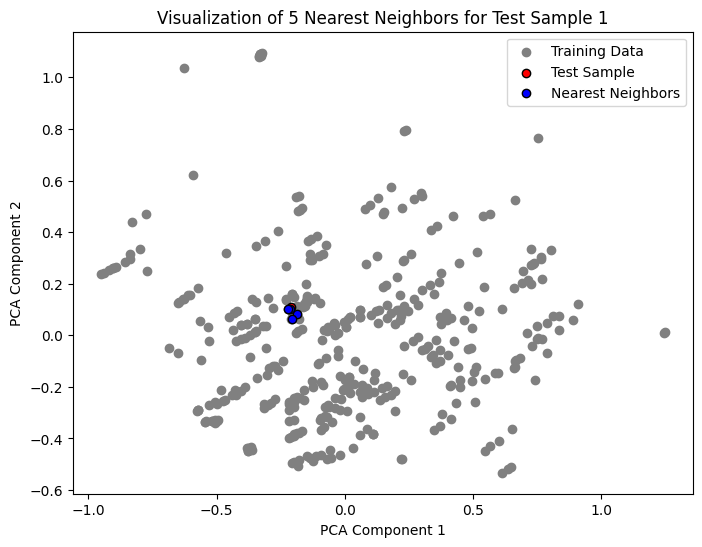

In [100]:
from sklearn.decomposition import PCA

# Reduce features to 2D using PCA
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train)
X_test_2d = pca.transform(X_test)

# Visualize the first test sample and its neighbors
test_sample_idx = 0
neighbors_idx = indices[test_sample_idx]

plt.figure(figsize=(8, 6))
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c='gray', label='Training Data')
plt.scatter(X_test_2d[test_sample_idx, 0], X_test_2d[test_sample_idx, 1], c='red', label='Test Sample', edgecolor='black')
plt.scatter(X_train_2d[neighbors_idx, 0], X_train_2d[neighbors_idx, 1], c='blue', label='Nearest Neighbors', edgecolor='black')
plt.legend()
plt.title(f'Visualization of {k} Nearest Neighbors for Test Sample {test_sample_idx + 1}')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [94]:
counter = 0
for (d, theta), accuracies in results.items():
    print(f"{d},{theta} ==> {max(accuracies.values()):.2f}")
    if max(accuracies.values()):
        print(f"Best k for d={d}, theta={theta}: {max(accuracies, key=accuracies.get)}")
        max_accuracy = max(accuracies.values())
    print('=----------------=')
    if max_accuracy > counter:
        counter = max_accuracy
        best_combination = (d, theta)
        best_k = max(accuracies, key=accuracies.get)

print(f"Best combination: d={best_combination[0]}, theta={best_combination[1]} with k={best_k} and accuracy={counter:.2f}")

1,0 ==> 0.92
Best k for d=1, theta=0: 3
=----------------=
1,45 ==> 0.93
Best k for d=1, theta=45: 3
=----------------=
1,90 ==> 0.92
Best k for d=1, theta=90: 3
=----------------=
1,135 ==> 0.91
Best k for d=1, theta=135: 3
=----------------=
2,0 ==> 0.93
Best k for d=2, theta=0: 3
=----------------=
2,45 ==> 0.93
Best k for d=2, theta=45: 3
=----------------=
2,90 ==> 0.92
Best k for d=2, theta=90: 3
=----------------=
2,135 ==> 0.91
Best k for d=2, theta=135: 3
=----------------=
3,0 ==> 0.93
Best k for d=3, theta=0: 3
=----------------=
3,45 ==> 0.91
Best k for d=3, theta=45: 3
=----------------=
3,90 ==> 0.88
Best k for d=3, theta=90: 3
=----------------=
3,135 ==> 0.90
Best k for d=3, theta=135: 3
=----------------=
Best combination: d=1, theta=45 with k=3 and accuracy=0.93


In [28]:
df_ngetestt

,contrast,dissimilarity,homogeneity,energy,correlation,ASM,image,label,sum_of_squares,sum_average,sum_variance,sum_entropy,difference_variance,difference_entropy,IMC1,IMC2
0,0.388348,0.408145,0.617841,0.590300,0.717443,0.371175,img-0,0,0.460236,0.560117,0.460236,0.408126,9.362202e-36,0.533927,0.298391,NaN
1,0.154782,0.238894,0.440042,0.298628,0.725386,0.108856,img-1,0,0.672754,0.763993,0.672754,0.657288,1.651575e-36,0.271991,0.214397,NaN
2,0.177811,0.307529,0.523025,0.502253,0.641505,0.275745,img-2,0,0.756977,0.824276,0.756977,0.443785,1.791497e-35,0.590290,0.457538,NaN
3,0.180857,0.311045,0.358921,0.283670,0.681110,0.099559,img-3,0,0.672499,0.763888,0.672499,0.664103,2.391409e-36,0.306923,0.342728,NaN
4,0.154079,0.240034,0.426750,0.279261,0.725693,0.096896,img-4,0,0.672250,0.763758,0.672250,0.669612,5.599573e-36,0.422810,0.221138,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.178135,0.400121,0.332368,0.386505,0.608627,0.171663,img-495,4,0.565217,0.696990,0.565217,0.387562,5.066966e-36,0.354036,0.892294,NaN
496,0.169526,0.421155,0.319794,0.371579,0.624948,0.160008,img-496,4,0.564271,0.696376,0.564271,0.398348,8.587875e-36,0.413100,0.897512,NaN
497,0.649062,0.787587,0.502101,0.615242,0.721954,0.400762,img-497,4,0.303774,0.357917,0.303774,0.403551,1.967817e-35,0.601896,0.546548,NaN
498,0.619151,0.462943,0.951568,0.992337,0.769374,0.985447,img-498,4,0.580902,0.577221,0.580902,0.000000,1.204132e-35,0.474002,0.263788,NaN


In [34]:
df_ngetestt.describe()

,contrast,dissimilarity,homogeneity,energy,correlation,ASM,label,sum_of_squares,sum_average,sum_variance,sum_entropy,difference_variance,difference_entropy,IMC1,IMC2
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.000000,500.000000,5.000000e+02,500.000000,500.000000,0.0
mean,0.254556,0.353209,0.420504,0.362497,0.700807,0.200382,2.00000,0.553020,0.651332,0.553020,0.584235,6.171033e-36,0.383499,0.372520,NaN
std,0.177414,0.181476,0.212487,0.228632,0.147637,0.203946,1.41563,0.175724,0.153878,0.175724,0.182174,6.411770e-36,0.183102,0.201630,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,NaN
25%,0.129870,0.239488,0.249836,0.176099,0.624991,0.044642,1.00000,0.449915,0.550634,0.449915,0.456708,1.963512e-36,0.241224,0.220597,NaN
50%,0.221493,0.326084,0.397884,0.335185,0.721698,0.133284,2.00000,0.559438,0.651261,0.559438,0.599491,4.621958e-36,0.356938,0.341950,NaN
75%,0.329472,0.444738,0.595152,0.515907,0.779124,0.289624,3.00000,0.683469,0.774297,0.683469,0.723421,8.317508e-36,0.502255,0.526619,NaN
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.00000,1.000000,1.000000,1.000000,1.000000,5.167714e-35,1.000000,1.000000,NaN


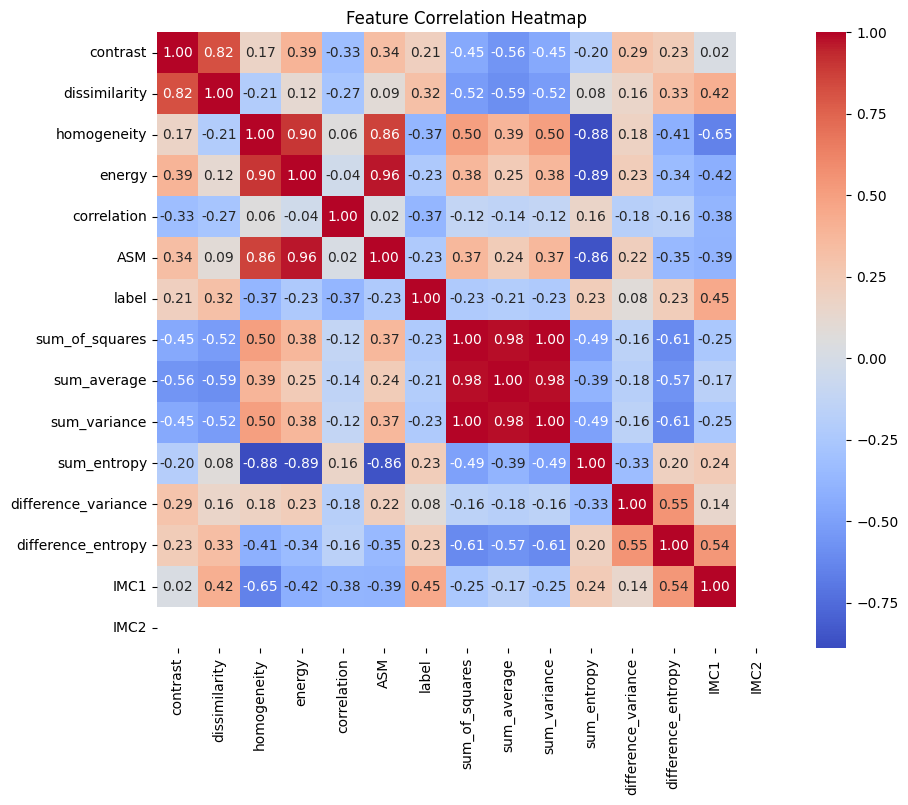

In [40]:
# Calculate and visualize the correlation matrix
correlation_matrix = df_ngetestt.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

## TEST

In [41]:
df = df_ngetestt.copy()

In [42]:
df.head()

,contrast,dissimilarity,homogeneity,energy,correlation,ASM,label,sum_of_squares,sum_average,sum_variance,sum_entropy,difference_variance,difference_entropy,IMC1,IMC2
image,,,,,,,,,,,,,,,
img-0,0.388348,0.408145,0.617841,0.590300,0.717443,0.371175,0,0.460236,0.560117,0.460236,0.408126,9.362202e-36,0.533927,0.298391,NaN
img-1,0.154782,0.238894,0.440042,0.298628,0.725386,0.108856,0,0.672754,0.763993,0.672754,0.657288,1.651575e-36,0.271991,0.214397,NaN
img-2,0.177811,0.307529,0.523025,0.502253,0.641505,0.275745,0,0.756977,0.824276,0.756977,0.443785,1.791497e-35,0.590290,0.457538,NaN
img-3,0.180857,0.311045,0.358921,0.283670,0.681110,0.099559,0,0.672499,0.763888,0.672499,0.664103,2.391409e-36,0.306923,0.342728,NaN
img-4,0.154079,0.240034,0.426750,0.279261,0.725693,0.096896,0,0.672250,0.763758,0.672250,0.669612,5.599573e-36,0.422810,0.221138,NaN


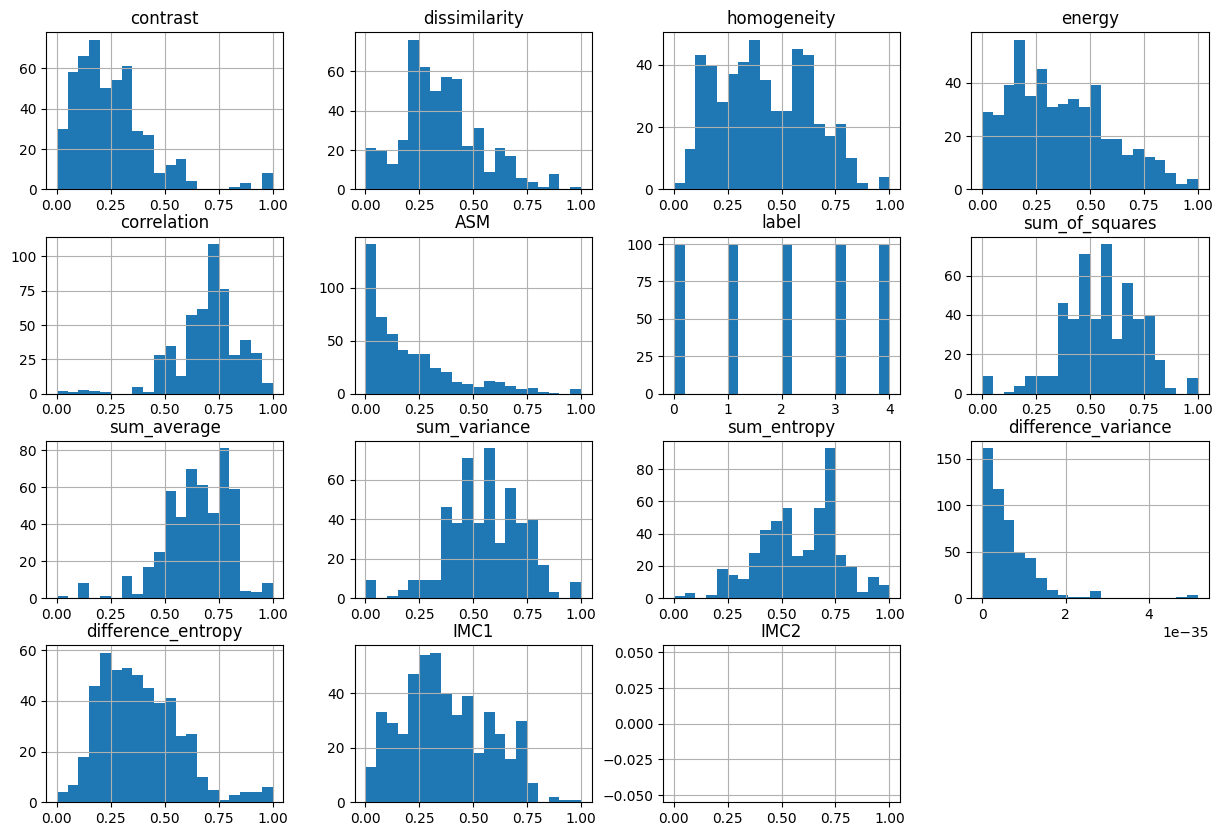

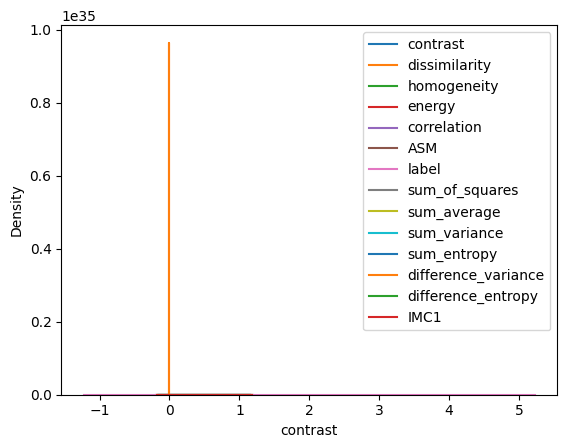

In [43]:
# Plot histograms for each feature
df.hist(bins=20, figsize=(15, 10))
plt.show()

# Plot density plots for selected features
for col in df.columns[:-1]:  # Exclude 'image' and 'label'
    sns.kdeplot(df[col], label=col)
plt.legend()
plt.show()

## Handling Outlier

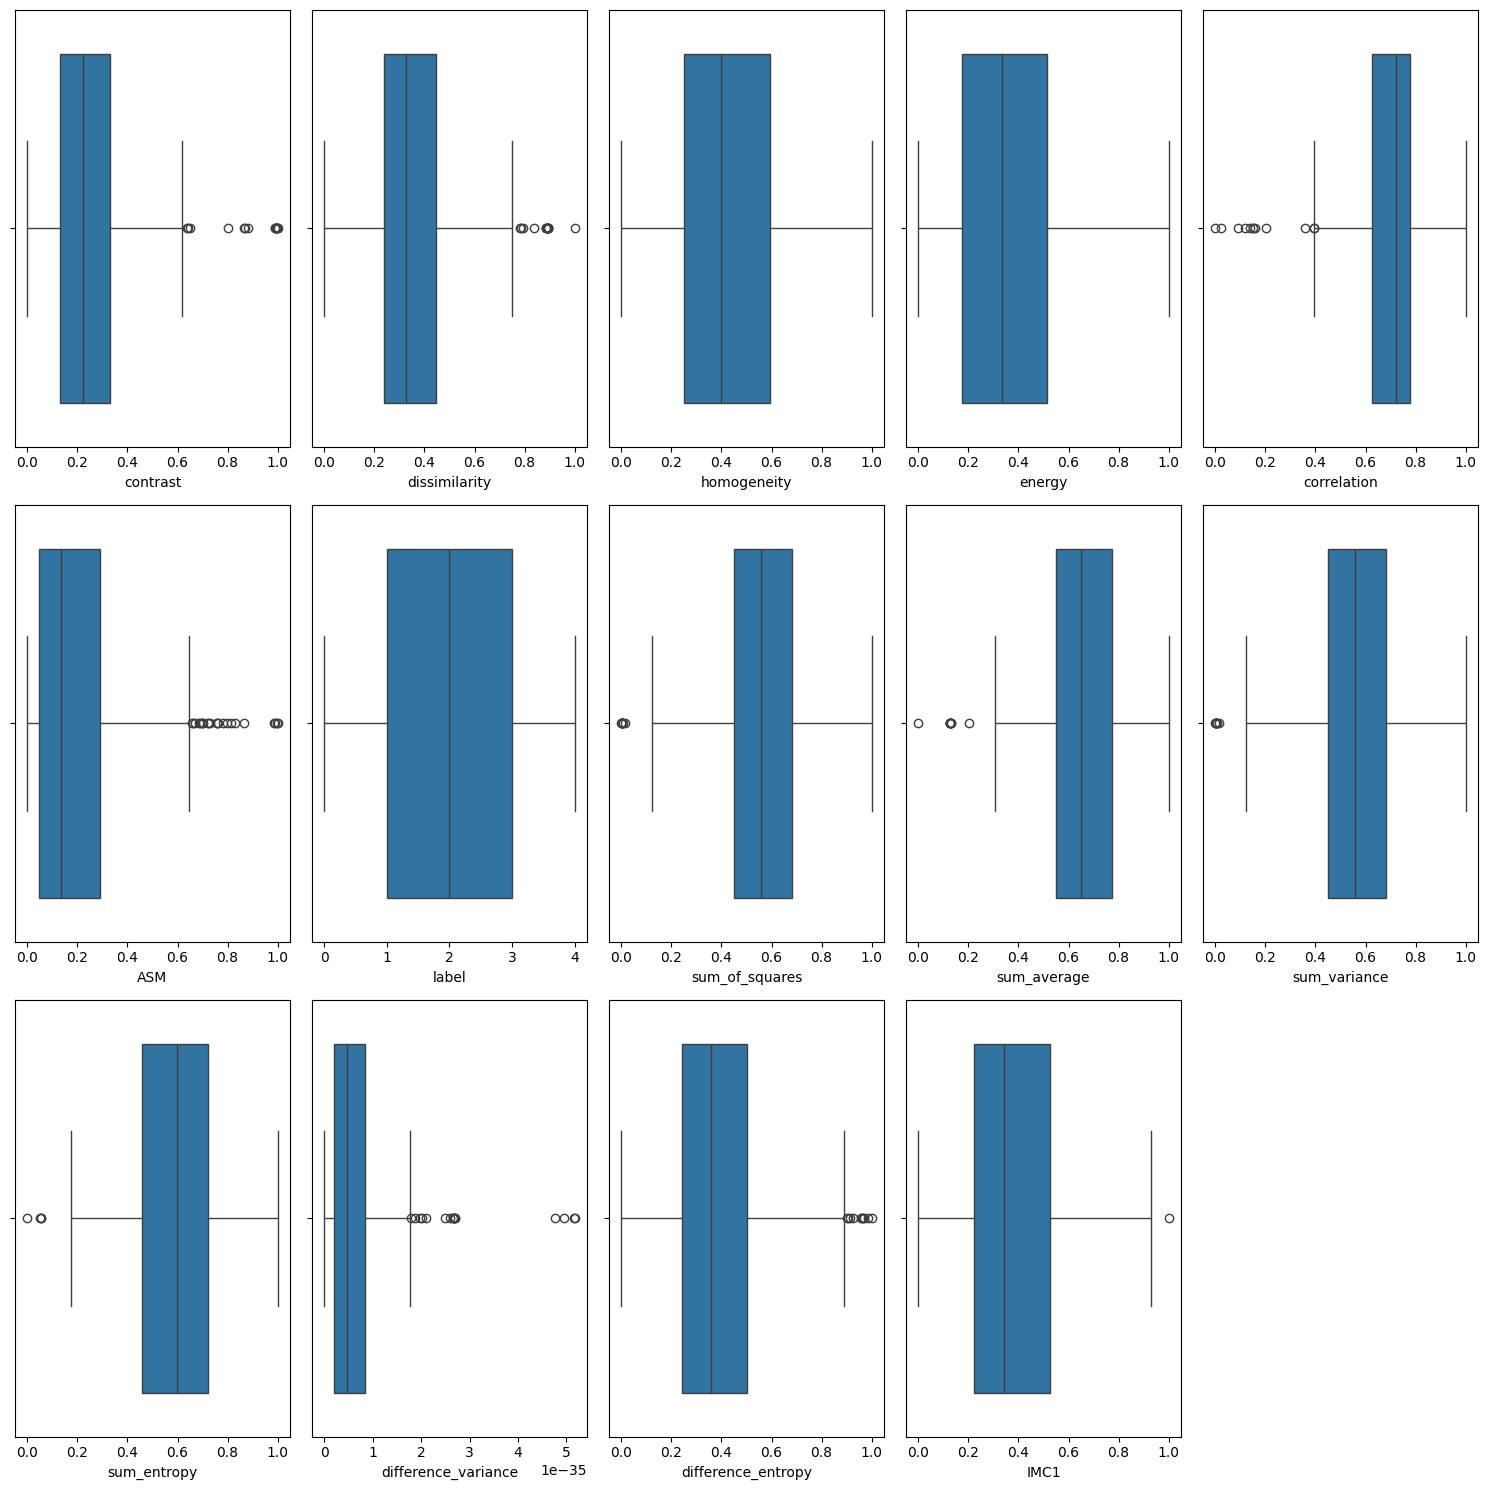

In [45]:
# Cek outlier dengan visualisasi dalam 3 baris
# Tentukan jumlah kolom per baris
cols_per_row = 5
num_features = len(df.columns[:-1])  # tanpa 'label'
num_rows = math.ceil(num_features / cols_per_row)  # Hitung jumlah baris

fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(15, 5 * num_rows))
axes = axes.flatten()  # Flatten untuk iterasi yang mudah

for i, col in enumerate(df.columns[:-1]):  # tanpa 'label'
    sns.boxplot(x=df[col], ax=axes[i])
    # axes[i].set_title(f"Outliers in Feature: {col}")

# Hapus subplot kosong jika jumlah fitur tidak habis dibagi jumlah kolom
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Terlihat pada setiap fitur ada outliernya dan hanya fitur sum_average saja yang tidak memiliki nilai outlier, maka dari itu perlu dilakukan pengolahan data untuk menghilangkan outlier tersebut. 
Teknik yang akan digunakan di sini adalah *Interquartil Range* 

Mengumpulkan kelompok fitur berdasarkan distribusinya

In [60]:
getcolumns = df.columns[0:6].tolist() + df.columns[7:14].tolist()
getcolumns

['contrast',
 'dissimilarity',
 'homogeneity',
 'energy',
 'correlation',
 'ASM',
 'sum_of_squares',
 'sum_average',
 'sum_variance',
 'sum_entropy',
 'difference_variance',
 'difference_entropy',
 'IMC1']

Akan dilakukan proses pengisian outlier dengan teknik *Imputation*

In [46]:
# Fungsi untuk proses imputation
def handle_asymmetric_outliers(series, lower_factor=1.5, upper_factor=1.5):
    """
    Menangani outlier asimetris dalam kolom Pandas Series.

    Args:
        series (pd.Series): Pandas Series yang akan diproses.
        lower_factor (float): Faktor IQR untuk batas bawah.
        upper_factor (float): Faktor IQR untuk batas atas.

    Returns:
        pd.Series: Pandas Series dengan outlier yang sudah ditangani.
    """

    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - (lower_factor * IQR)
    upper_bound = Q3 + (upper_factor * IQR)

    modified_series = np.where(series < lower_bound, lower_bound, series)
    modified_series = np.where(modified_series > upper_bound, upper_bound, modified_series)

    return modified_series

In [61]:
# Proses imputation untuk outlier ekstrem
# for feature in right_skew + left_skew:
for feature in getcolumns:
    # Sesuaikan nilai outlier
    df[feature] = handle_asymmetric_outliers(df[feature], lower_factor=1.5, upper_factor=1.5)

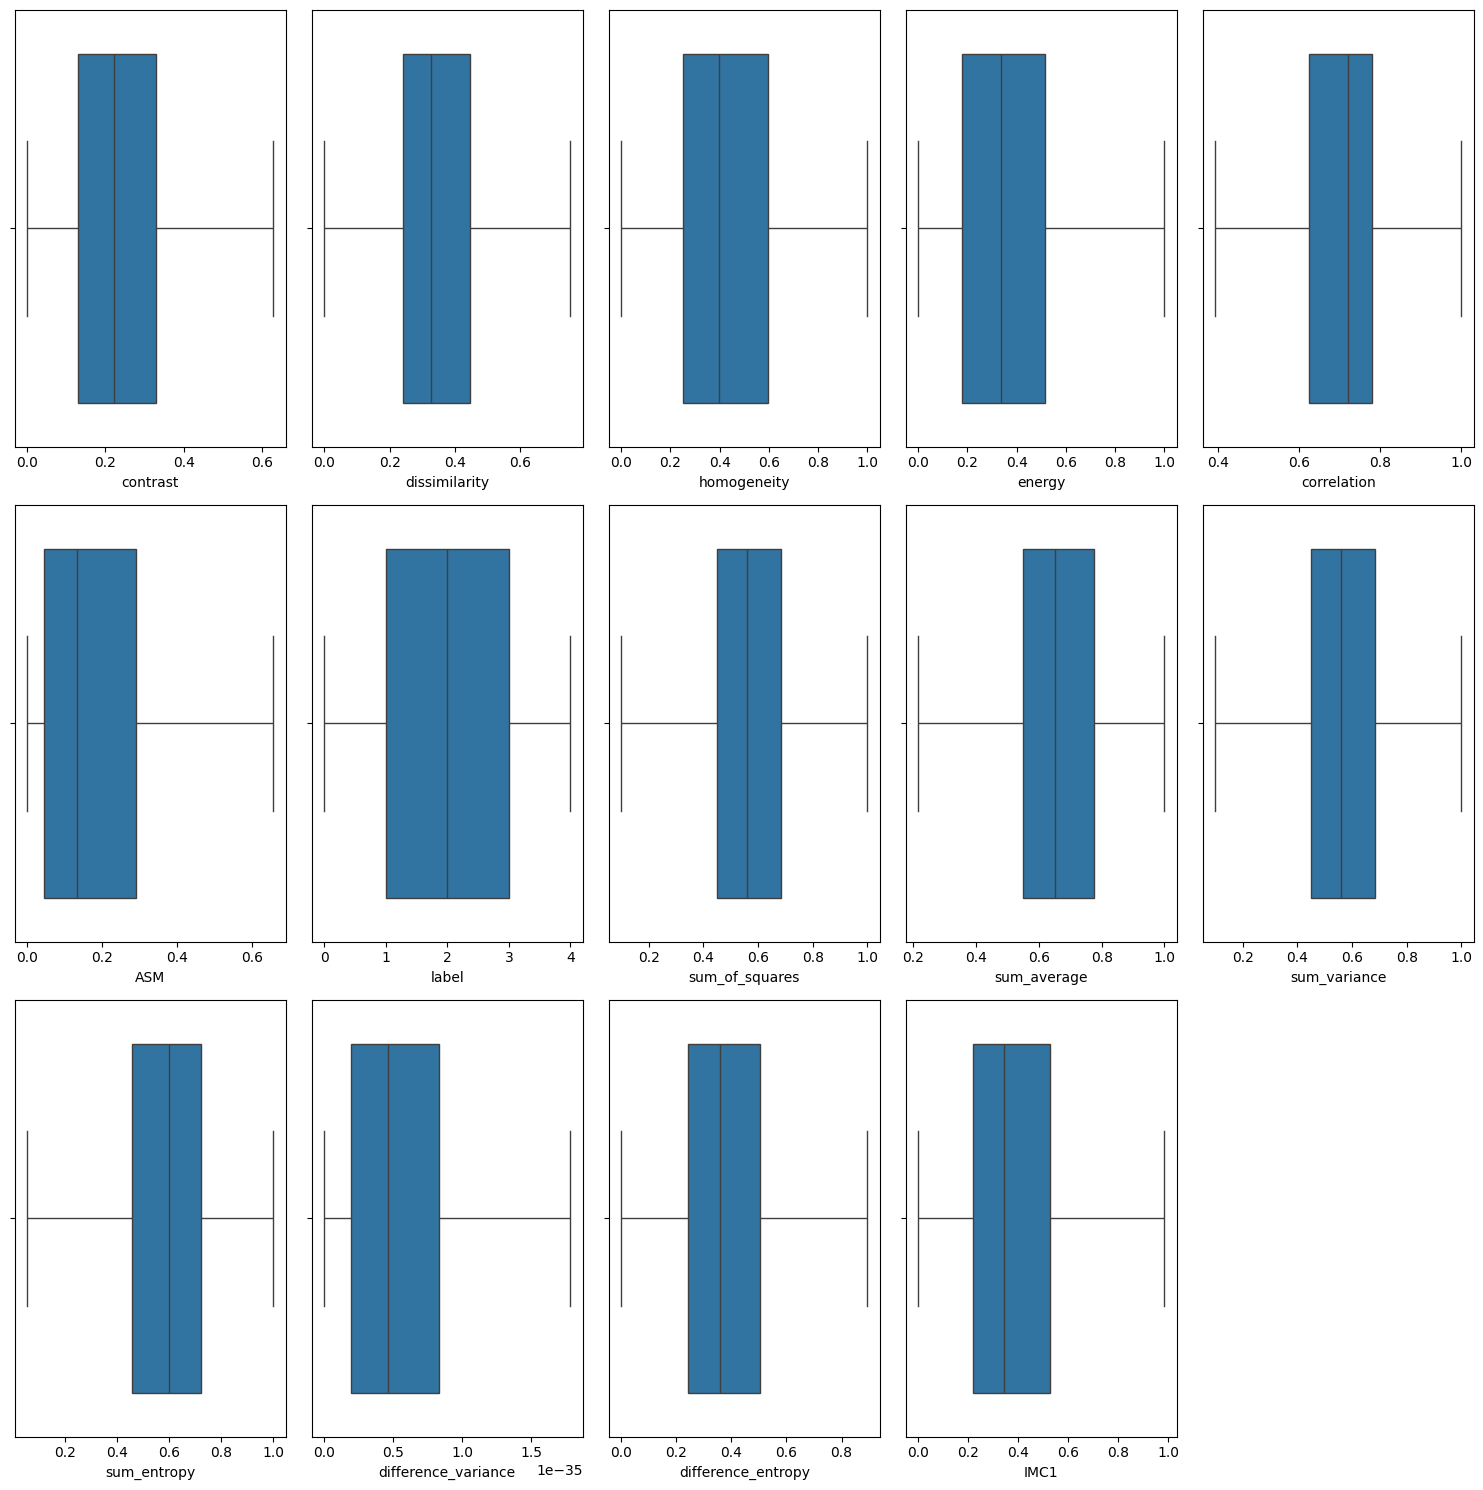

In [62]:
# Cek kembali box plot untuk melihat hasil imputation
cols_per_row = 5
num_features = len(df.columns[:-1])  # tanpa 'label'
num_rows = math.ceil(num_features / cols_per_row)  # Hitung jumlah baris

fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(15, 5 * num_rows))
axes = axes.flatten()  # Flatten untuk iterasi yang mudah

for i, col in enumerate(df.columns[:-1]):  # tanpa 'label'
    sns.boxplot(x=df[col], ax=axes[i])
    # axes[i].set_title(f"Outliers in Feature: {col}")

# Hapus subplot kosong jika jumlah fitur tidak habis dibagi jumlah kolom
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Terlihat Outlier sudah hilang, sekarang akan dilanjutkan ke proses selanjutnya.

## Transform & Normalize

Sekarang mari cek lagi sebaran datanya

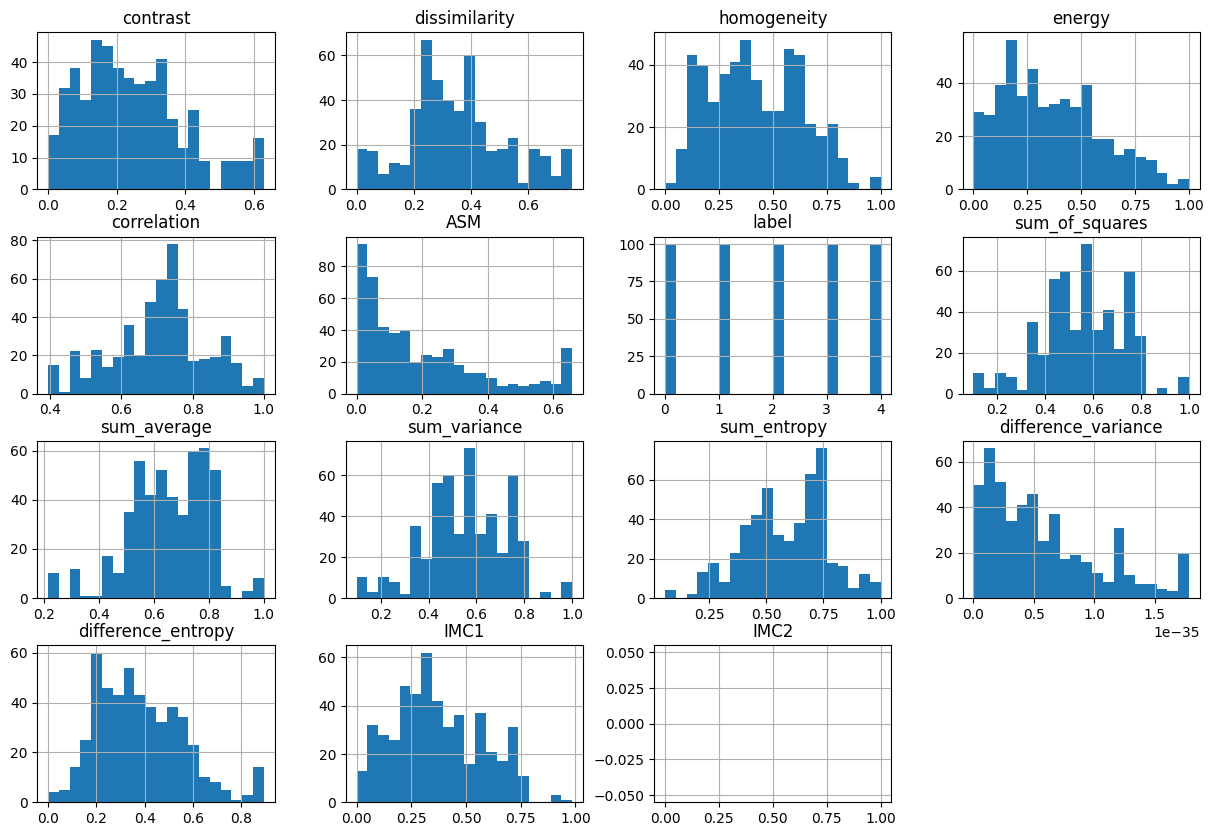

In [63]:
# Plot histograms for each feature
df.hist(bins=20, figsize=(15, 10))
plt.show()

Karena sebaran datanya rangenya itu berbeda jauh, maka akan dinormalisasi. Selain itu, akan digunakan model KNN pada fitur-fitur ini sehingga diperlukan normalisasi karena KNN sensitif terhadap skala data. Akan digunakan min-max scaler untuk mengubah skala data menjadi antara 0 dan 1.

In [64]:
# Cek skewness
skewness = df.skew()
print(skewness)

contrast               0.691796
dissimilarity          0.346395
homogeneity            0.230112
energy                 0.532210
correlation           -0.280872
ASM                    1.120006
label                  0.000000
sum_of_squares        -0.137803
sum_average           -0.518096
sum_variance          -0.137803
sum_entropy           -0.254435
difference_variance    0.000000
difference_entropy     0.663814
IMC1                   0.335945
IMC2                        NaN
dtype: float64


In [67]:
numeric_features = df.columns[:-1]
numeric_features

Index(['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation',
       'ASM', 'label', 'sum_of_squares', 'sum_average', 'sum_variance',
       'sum_entropy', 'difference_variance', 'difference_entropy', 'IMC1'],
      dtype='object')

In [81]:
def log_transform(series, add_constant=True):
    """
    Melakukan transformasi logaritma pada Pandas Series.

    Args:
        series (pd.Series): Pandas Series yang akan ditransformasi.
        add_constant (bool): Menambahkan konstanta kecil jika ada nilai nol atau negatif.

    Returns:
        pd.Series: Pandas Series yang ditransformasi.
    """

    if add_constant and (series <= 0).any():
        min_positive = series[series > 0].min()
        series = series + min_positive

    transformed_series = np.log1p(series)
    return transformed_series

In [82]:
# Step 2: Apply log transformation (handle zeros by adding a small constant)
df_log_transformed = df.copy()
 # log1p(x) = log(1 + x)# Applying Square Root Transformation
df_log_transformed['ASM'] = log_transform(df_log_transformed['ASM'])
df_log_transformed['difference_variance'] = log_transform(df_log_transformed['difference_variance'])

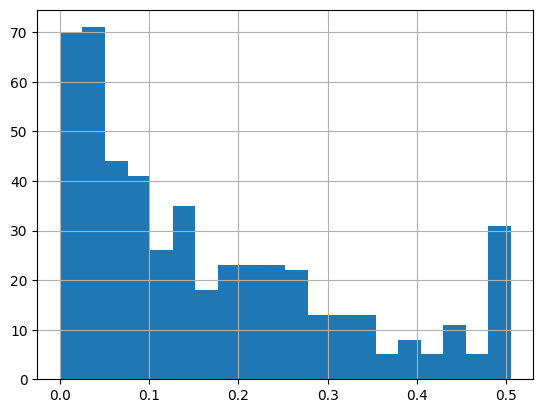

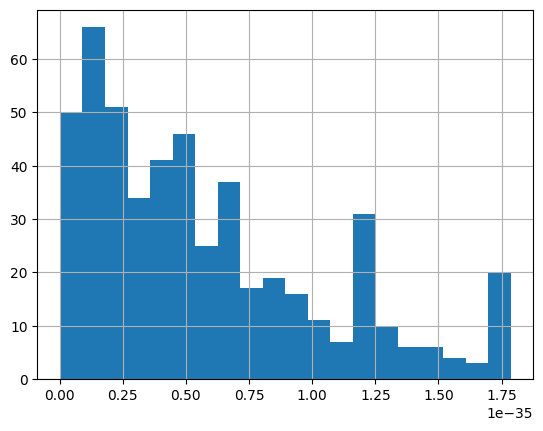

In [83]:
df_log_transformed['ASM'].hist(bins=20)
plt.show()
df_log_transformed['difference_variance'].hist(bins=20)
plt.show()

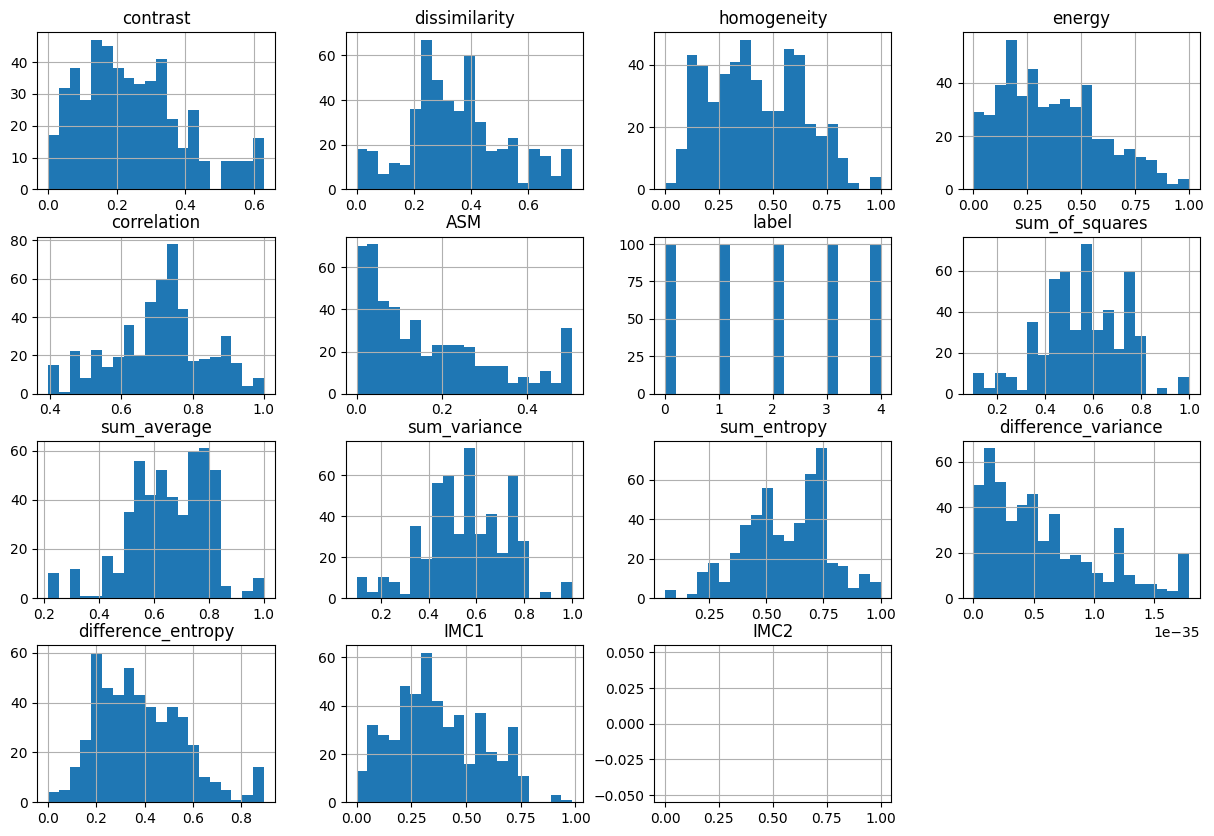

In [101]:
df_log_transformed.hist(bins=20, figsize=(15, 10))
plt.show()

In [325]:
testtt = df_log_transformed.columns[:-1]
df_log_transformed[testtt] = scaler.fit_transform(df_log_transformed[testtt])


In [84]:
from classifier.knn import KNN
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

Classifier package loaded!


In [85]:
ngetest = df_log_transformed.copy()
ngetest = ngetest.drop(columns=['IMC2'])
ngetest

,contrast,dissimilarity,homogeneity,energy,correlation,ASM,label,sum_of_squares,sum_average,sum_variance,sum_entropy,difference_variance,difference_entropy,IMC1
image,,,,,,,,,,,,,,
img-0,0.388348,0.408145,0.617841,0.590300,0.717443,0.315725,0,0.460236,0.560117,0.460236,0.408126,9.376427e-36,0.533927,0.298391
img-1,0.154782,0.238894,0.440042,0.298628,0.725386,0.103399,0,0.672754,0.763993,0.672754,0.657288,1.665799e-36,0.271991,0.214397
img-2,0.177811,0.307529,0.523025,0.502253,0.641505,0.243591,0,0.756977,0.824276,0.756977,0.443785,1.786272e-35,0.590290,0.457538
img-3,0.180857,0.311045,0.358921,0.283670,0.681110,0.094980,0,0.672499,0.763888,0.672499,0.664103,2.405634e-36,0.306923,0.342728
img-4,0.154079,0.240034,0.426750,0.279261,0.725693,0.092555,0,0.672250,0.763758,0.672250,0.669612,5.613797e-36,0.422810,0.221138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
img-495,0.178135,0.400121,0.332368,0.386505,0.608627,0.158490,4,0.565217,0.696990,0.565217,0.387562,5.081190e-36,0.354036,0.892294
img-496,0.169526,0.421155,0.319794,0.371579,0.624948,0.148494,4,0.564271,0.696376,0.564271,0.398348,8.602099e-36,0.413100,0.897512
img-497,0.628874,0.752613,0.502101,0.615242,0.721954,0.337072,4,0.303774,0.357917,0.303774,0.403551,1.786272e-35,0.601896,0.546548


In [86]:
X_train, X_test, y_train, y_test = train_test_split(ngetest.drop(columns=['label']), ngetest['label'], test_size=0.2, random_state=42)

In [87]:
for k in range(3, 4):  # Mencoba k dari 3 sampai 15
    model = KNN(k=k)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(acc, prec, rec, f1)

0.9 0.9111233766233766 0.9 0.8927482632310219
